In [66]:
import os
# Force TensorFlow/Keras to use CPU only to avoid MPS float64 errors
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
try:
    tf.config.set_visible_devices([], 'GPU')
    print("GPU Disabled. Running on CPU to support float64.")
except:
    pass

GPU Disabled. Running on CPU to support float64.


## Part A: Global Setup and Data Loading

In this section, we set up the environment, define configuration parameters, and implement helper functions to load datasets from the UCR/UEA archive. We also perform MinMax scaling, which is crucial for distance-based algorithms to function correctly.

### 1. Configuration and Hyperparameters

Defining global constants for the dataset (default: GunPoint), optimizer settings, and shapelet parameters.

In [ ]:
import time
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from tslearn.neighbors import KNeighborsTimeSeriesClassifier


# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- CONFIGURATION ---
DATASET_NAME = "GunPoint"  # Change this to "GunPoint", "Coffee", "ECG200", etc.
SCALER = "minmax"          # "minmax", "zscore", or None
N_TEST_SUBSAMPLE = None    # Set to None for full test set, or int (e.g., 50)
SUBSAMPLE_SEED = 42


# Model Hyperparameters
K_SHAPELETS = 9           # Number of shapelets
SHAPELET_LEN_RATIO = 0.3   # Shapelet length as a fraction of time series length
ITERATIONS = 800
LR = 0.01
LAMBDA_W = 0.01            # Weight decay for linear layer
OPTIMIZER_NAME = 'AdamW'   # 'SGD' or 'AdamW'
INIT_MODE = 'random'    # 'random' or 'kmeans' or 'noise'
ALPHA = -100.0               # Sharpness parameter for soft-minimum

print(f"Configuration set for dataset: {DATASET_NAME}")

Configuration set for dataset: GunPoint


In [ ]:
# # CELL 2 — Data loading + preprocessing (+ optional test subsample)
# # (Helper functions from your provided code)

# def standardize_ucr_name(name):
#     # Simple helper to fix common naming issues if needed, otherwise pass through
#     return name

# def load_ucr(dataset_name="GunPoint", scaler="minmax"):
#     dataset_name = standardize_ucr_name(dataset_name)
#     ucr = UCR_UEA_datasets()
#     # Note: explicit load might be needed for some versions of tslearn
#     try:
#         X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)
#     except:
#         print(f"Dataset {dataset_name} not found in cache, downloading...")
#         X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)

#     if X_train is None:
#         raise ValueError(f"Could not load dataset: {dataset_name}")

#     if scaler == "minmax":
#         sc = TimeSeriesScalerMinMax()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)
#     elif scaler == "zscore":
#         sc = TimeSeriesScalerMeanVariance()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)
#     elif scaler in (None, "none"):
#         pass
#     else:
#         raise ValueError(f"Unknown scaler={scaler}")

#     le = LabelEncoder()
#     y_train_enc = le.fit_transform(y_train)
#     y_test_enc = le.transform(y_test)

#     meta = {
#         "dataset": dataset_name,
#         "n_train": X_train.shape[0],
#         "n_test": X_test.shape[0],
#         "ts_len": X_train.shape[1],
#         "n_channels": X_train.shape[2],
#         "n_classes": len(np.unique(y_train_enc)),
#         "classes": list(le.classes_),
#         "label_encoder": le,
#         "scaler": scaler,
#     }
#     return X_train, y_train_enc, X_test, y_test_enc, meta


# def subsample_test_set(X_test, y_test, n_test_subsample=10, subsample_seed=0):
#     if n_test_subsample is None or n_test_subsample >= len(y_test):
#         meta_sub = {
#             "n_test_full": len(y_test),
#             "test_subsample_indices": list(range(len(y_test))),
#         }
#         return X_test, y_test, meta_sub

#     rng = np.random.default_rng(subsample_seed)
#     classes = np.unique(y_test)

#     per_class = max(1, n_test_subsample // len(classes))
#     chosen = []
#     for c in classes:
#         idx = np.where(y_test == c)[0]
#         take = min(per_class, len(idx))
#         chosen.extend(rng.choice(idx, size=take, replace=False).tolist())

#     chosen = np.array(sorted(set(chosen)), dtype=int)
#     if len(chosen) < n_test_subsample:
#         remaining = np.setdiff1d(np.arange(len(y_test)), chosen, assume_unique=False)
#         extra = rng.choice(
#             remaining, size=n_test_subsample - len(chosen), replace=False
#         )
#         chosen = np.concatenate([chosen, extra])

#     rng.shuffle(chosen)

#     meta_sub = {"n_test_full": len(y_test), "test_subsample_indices": chosen.tolist()}
#     return X_test[chosen], y_test[chosen], meta_sub

### 2) Data Loading & Preprocessing

We utilize tslearn to fetch datasets. The data is normalized so that all time series values fall within [0,1].

In [ ]:
# CELL 2b — Use data functions immediately

# Load Data
X_train, y_train, X_test, y_test, meta = load_ucr(DATASET_NAME, scaler=SCALER)

# Subsample Test Set (if configured)
X_test, y_test, meta_sub = subsample_test_set(
    X_test, y_test, n_test_subsample=N_TEST_SUBSAMPLE, subsample_seed=SUBSAMPLE_SEED
)

# Merge Meta Info
meta["n_test_full"] = meta_sub["n_test_full"]
meta["n_test"] = len(y_test)
meta["test_subsample_indices"] = meta_sub["test_subsample_indices"]

# Calculate Dynamic Shapelet Length (e.g., 30% of TS length)
# We ensure it is at least 1
calculated_shapelet_len = max(1, int(meta['ts_len'] * SHAPELET_LEN_RATIO))

print("=== Dataset meta ===")
for k in ["dataset", "n_train", "n_test", "ts_len", "n_classes", "scaler"]:
    print(f"{k}: {meta[k]}")
print(f"Shapelet Params: K={K_SHAPELETS}, L={calculated_shapelet_len} (Ratio: {SHAPELET_LEN_RATIO})")

=== Dataset meta ===
dataset: GunPoint
n_train: 50
n_test: 150
ts_len: 150
n_classes: 2
scaler: minmax
Shapelet Params: K=9, L=45 (Ratio: 0.3)


## Part B: PyTorch Model Definition of Learning Shapelets

In this section, we define the core neural network architecture. The model is designed to learn a set of discriminative subsequences (shapelets) that can classify time series based on local similarity.

### 1. Mathematical Formulation

The model learns a set of $K$ shapelets, denoted as $S$. The fundamental operation is calculating the distance between a time series $T_i$ and a shapelet $S_k$. This is defined as the minimum squared Euclidean distance across all possible sliding windows of the time series.

However, the standard `min` operator is non-differentiable, which prevents backpropagation. To solve this, we use the differentiable **Soft-Minimum** function:

$$
M_{k,i} \approx \frac{\sum_{j} d_{k,i,j} \cdot e^{\alpha \cdot d_{k,i,j}}}{\sum_{j} e^{\alpha \cdot d_{k,i,j}}}
$$

Where:
* $d_{k,i,j}$ is the squared Euclidean distance between the $k$-th shapelet and the $j$-th segment of the $i$-th time series.
* $\alpha$ (typically set to -100) controls the sharpness of the approximation. As $\alpha \to -\infty$, the function approaches the true hard minimum.

### 2. Implementation Details

Our custom PyTorch implementation introduces several architectural optimizations:

* **`ShapeletBlock`**: A specialized module dedicated to a specific shapelet length $L$. It utilizes `torch.unfold` to vectorize the sliding window extraction, allowing the model to compute distances for all windows in parallel without loop overhead.
* **`LearningShapeletsModel`**: The main container that aggregates multiple `ShapeletBlock` instances (enabling multi-scale shapelets of different lengths) and passes the resulting distance vector to a linear classifier.
* **Initialization**: We implement distinct strategies to study convergence behavior:
    * `random_noise`: Initializes shapelets with Gaussian noise (used to demonstrate the vanishing gradient failure mode).
    * `random_window`: Initializes shapelets by copying random subsequences from the training data (ensures immediate valid gradient flow).

In [163]:
class ShapeletBlock(nn.Module):
    """
    A single block responsible for shapelets of a SPECIFIC length.
    """
    def __init__(self, n_shapelets, shapelet_length):
        super(ShapeletBlock, self).__init__()
        self.n_shapelets = n_shapelets
        self.shapelet_length = shapelet_length
        # Initialize random weights for this block
        self.shapelets = nn.Parameter(torch.randn(n_shapelets, shapelet_length))
        
    def forward(self, x, alpha):
        # x: (Batch, Time)
        # 1. Unfold specifically for THIS length
        x_unfolded = x.unfold(1, self.shapelet_length, 1)
        
        # 2. Compute Distances
        x_expanded = x_unfolded.unsqueeze(2)
        s_expanded = self.shapelets.view(1, 1, self.n_shapelets, self.shapelet_length)
        
        dist_sq = torch.sum((x_expanded - s_expanded) ** 2, dim=3)
        dist_sq = dist_sq / self.shapelet_length 
        
        # 3. Soft-Min
        weights = torch.exp(alpha * dist_sq)
        soft_min_dist = torch.sum(dist_sq * weights, dim=1) / (torch.sum(weights, dim=1) + 1e-8)
        
        return soft_min_dist


class LearningShapeletsModel(nn.Module):
    def __init__(self, shapelets_dict, input_length, num_classes, alpha):
        """
        Args:
            shapelets_dict: Dictionary {length: number_of_shapelets}
                            e.g. {20: 3, 40: 5} -> 3 shapelets of len 20, 5 of len 40
        """
        super(LearningShapeletsModel, self).__init__()
        
        self.alpha = alpha
        self.blocks = nn.ModuleList()
        
        total_shapelets = 0
        
        # Create a block for each length size
        for length, count in shapelets_dict.items():
            self.blocks.append(ShapeletBlock(n_shapelets=count, shapelet_length=length))
            total_shapelets += count
            
        # Linear layer takes the concatenation of ALL shapelet distances
        self.linear = nn.Linear(total_shapelets, num_classes)
        
    def forward(self, x):
        features = []
        # Loop through each length-block
        for block in self.blocks:
            # Each block handles its own unfolding and distance calculation
            features.append(block(x, self.alpha))
            
        # Concatenate all distances: (Batch, Total_K)
        all_features = torch.cat(features, dim=1)
        
        output = self.linear(all_features)
        return output, all_features

    def initialize_random_noise(self):
        """
        Explicitly initializes shapelets with Random Gaussian Noise.
        Used to demonstrate the Vanishing Gradient problem.
        """
        print(f"-> Initializing shapelets via Random Gaussian Noise (Standard Normal)...")
        for block in self.blocks:
            # Re-sample from N(0, 1)
            block.shapelets.data = torch.randn(
                block.n_shapelets, 
                block.shapelet_length, 
                dtype=torch.float32
            )
        print("-> Shapelets reset to pure noise.")

    def initialize_random_windows(self, X_train):
        print(f"-> Initializing shapelets via Random Window Sampling...")
        
        # Loop through each block to initialize its specific shapelets
        for block in self.blocks:
            n_shp = block.n_shapelets
            length = block.shapelet_length
            
            # Logic similar to before, but adapted for the block
            n_samples = X_train.shape[0]
            ts_len = X_train.shape[-1] if X_train.ndim == 2 else X_train.shape[1]
            
            random_ts_indices = np.random.choice(n_samples, n_shp, replace=True)
            random_start_times = np.random.randint(0, ts_len - length, n_shp)
            
            initial_shapelets = []
            for i in range(n_shp):
                ts_idx = random_ts_indices[i]
                start = random_start_times[i]
                
                if X_train.ndim == 2:
                    window = X_train[ts_idx, start : start + length]
                else:
                    window = X_train[ts_idx, start : start + length, 0]
                initial_shapelets.append(window)
                
            block.shapelets.data = torch.tensor(np.array(initial_shapelets), dtype=torch.float32)
            
        print(f"-> All shapelet blocks initialized.")

    def initialize_kmeans(self, X_train):
        print(f"-> Running K-Means initialization per block...")
        limit_windows = 10000 
        
        for block in self.blocks:
            length = block.shapelet_length
            n_shp = block.n_shapelets
            
            print(f"   Block (L={length}): extracting windows...")
            
            windows = []
            n_samples = min(X_train.shape[0], 200)
            
            for i in range(n_samples): 
                for j in range(X_train.shape[1] - length + 1):
                    windows.append(X_train[i, j:j+length])
            
            windows = np.array(windows)
            if len(windows) > limit_windows:
                idx = np.random.choice(len(windows), limit_windows, replace=False)
                windows = windows[idx]
                
            kmeans = TimeSeriesKMeans(n_clusters=n_shp, metric="euclidean", max_iter=50, verbose=0)
            kmeans.fit(windows)
            
            block.shapelets.data = torch.tensor(kmeans.cluster_centers_.squeeze(), dtype=torch.float32)

## Part C: Comparative Analysis (GunPoint)

In this section, we train our PyTorch implementation and compare it against the standard tslearn library implementation on the binary GunPoint dataset.

### Paramater dictionary definition

In [164]:
param_dict = {
    'K_SHAPELETS': K_SHAPELETS,
    'calculated_shapelet_len': calculated_shapelet_len,
    'meta': meta,
    'LAMBDA_W': LAMBDA_W,
    'LR': LR,
    'OPTIMIZER_NAME': OPTIMIZER_NAME,
    'ITERATIONS': ITERATIONS,
    'INIT_MODE': INIT_MODE,
    'shapelets_dict': {calculated_shapelet_len: K_SHAPELETS//2 , calculated_shapelet_len//2: K_SHAPELETS//2},
    'ALPHA': ALPHA
}

### Test data formating Helper Functions

In [165]:
def pt_model_data(X,y):
    X_sq = X.squeeze()
    if X_sq.ndim == 1: X_sq = X_sq.unsqueeze(1)
    
    X_tensor = torch.tensor(X_sq, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

def ts_model_data(X,y):
    X_sq = X.squeeze()
    if X_sq.ndim == 2: X_sq = X_sq[:, :, np.newaxis]
    return X_sq, y

def override_shapelet_counts_with_k_frac(shapelet_sizes, ts_sz, k_frac):
    """
    Overrides the default Grabocka counts.
    Sets the number of shapelets for EACH length to int(k_frac * ts_sz).
    """
    k_fixed = int(k_frac * ts_sz)
    # Ensure at least 1 shapelet if k_frac is small but non-zero
    k_fixed = max(1, k_fixed) 
    
    new_sizes = {}
    for length in shapelet_sizes.keys():
        new_sizes[length] = k_fixed
    return new_sizes

In [166]:
if 'shapelets_dict' not in param_dict or param_dict['shapelets_dict'] is None:
    print(f"-> 'shapelets_dict' not found. Calculating via Grabocka heuristics...")
    n_ts = X_train.shape[0]
    ts_sz = X_train.shape[1]
    n_classes = meta['n_classes']
    l_param = param_dict.get('l', 0.1)
    r_param = param_dict.get('r', 1)
    k_frac = param_dict.get('k_frac', 0.0)
    
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(
        n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=float(l_param), r=int(r_param)
    )
    
    # Optional: Fixed K override on top of heuristic lengths
    if k_frac > 0.0:
        shapelet_sizes = override_shapelet_counts_with_k_frac(shapelet_sizes, ts_sz, k_frac)

### 1. Training Functions

Defining wrappers to handle the training loops for both PyTorch (with our custom Selective Weight Decay logic) and tslearn.

In [ ]:
# -----------------------------------------------------------------------------
# MODEL 1: PYTORCH IMPLEMENTATION
# -----------------------------------------------------------------------------

def pt_model_training(X_train, y_train, param_dict):
    # Unpack basic params
    meta = param_dict['meta']
    LAMBDA_W = param_dict['LAMBDA_W']
    LR = param_dict['LR']
    OPTIMIZER_NAME = param_dict['OPTIMIZER_NAME']
    ITERATIONS = param_dict['ITERATIONS']
    INIT_MODE = param_dict['INIT_MODE']
    ALPHA = param_dict['ALPHA']
    shapelet_sizes = param_dict['shapelets_dict']
    n_classes = meta['n_classes']
    ts_sz = meta['ts_len']
        
    total_shapelets = sum(shapelet_sizes.values())
    print(f"Training PyTorch Model ({OPTIMIZER_NAME}) for {ITERATIONS} iterations...")
    print(f"Config: {shapelet_sizes} (Total K={total_shapelets})")
    print(f"Initialization Mode: {INIT_MODE.upper()}")

    # -------------------------------------------------------------------------
    # INSTANTIATE MODEL
    # -------------------------------------------------------------------------
    start_time = time.time()

    # Note: We pass the 'shapelet_sizes' dict to the NEW class structure
    pt_model = LearningShapeletsModel(
        shapelets_dict=shapelet_sizes, 
        input_length=ts_sz, 
        num_classes=n_classes,
        alpha = ALPHA
    )

    # Prepare Data: (N, T)
    X_train_sq = X_train.squeeze()
    if X_train_sq.ndim == 1: X_train_sq = X_train_sq.unsqueeze(1) 

    # -------------------------------------------------------------------------
    # INITIALIZATION LOGIC
    # -------------------------------------------------------------------------
    # The model methods (initialize_kmeans / random) now handle looping over blocks internally
    if INIT_MODE.lower() == 'kmeans':
        pt_model.initialize_kmeans(X_train_sq)
    elif INIT_MODE.lower() == 'random':
        pt_model.initialize_random_windows(X_train_sq)
    elif INIT_MODE.lower() == 'noise': 
        pt_model.initialize_random_noise()
    else:
        print("WARNING: Using pure Gaussian noise. Model may not converge.")

    # -------------------------------------------------------------------------
    # OPTIMIZER SETUP (Multi-Block Support)
    # -------------------------------------------------------------------------
    # We must gather parameters from ALL ShapeletBlocks
    all_shapelet_params = []
    for block in pt_model.blocks:
        all_shapelet_params.extend(block.parameters())

    param_groups = [
        {'params': all_shapelet_params, 'weight_decay': 0.0}, # Shapelets: No decay
        {'params': pt_model.linear.parameters(), 'weight_decay': LAMBDA_W} # Linear: Decay
    ]

    if OPTIMIZER_NAME == 'AdamW':
        optimizer = optim.AdamW(param_groups, lr=LR)
    else:
        optimizer = optim.SGD(param_groups, lr=LR, momentum=0.9)

    loss_fn = nn.CrossEntropyLoss()

    # -------------------------------------------------------------------------
    # TRAIN LOOP
    # -------------------------------------------------------------------------
    print(f"Training on {meta['dataset']}...")
    X_tensor = torch.tensor(X_train_sq, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.long)

    for i in range(ITERATIONS):
        pt_model.train()
        optimizer.zero_grad()
        
        logits, _ = pt_model(X_tensor)
        loss = loss_fn(logits, y_tensor)
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Iter {i}: Loss = {loss.item():.4f}")
            
    pytorch_time = time.time() - start_time
    print("Training Complete.")
    
    # -------------------------------------------------------------------------
    # EXTRACT RESULTS
    # -------------------------------------------------------------------------
    # Since shapelets have different lengths, we cannot simply return one numpy array.
    # We return a list of arrays (one per block/length).
    shapelets_list = []
    for block in pt_model.blocks:
        shapelets_list.append(block.shapelets.detach().cpu().numpy())

    pt_dict = {
        'model': pt_model,
        'shapelets': shapelets_list, # List of numpy arrays [ (K1, L1), (K2, L2) ... ]
        'shapelet_sizes': shapelet_sizes,
        'time': pytorch_time
    }
    return pt_dict

In [ ]:
# -----------------------------------------------------------------------------
# MODEL 2: TSLEARN IMPLEMENTATION
# -----------------------------------------------------------------------------
def tslearn_model_training(X_train, y_train, param_dict):
    LAMBDA_W = param_dict['LAMBDA_W']
    OPTIMIZER_NAME = param_dict['OPTIMIZER_NAME']
    ITERATIONS = param_dict['ITERATIONS']
    shapelet_sizes = param_dict['shapelets_dict']

    print(f"Training tslearn Model for {ITERATIONS} iterations...")

    start_time = time.time()

    # Map our optimizer choice to tslearn's string options
    # tslearn supports 'sgd' and 'adam' (no specific 'adamw')
    ts_opt = 'adam' if 'adam' in OPTIMIZER_NAME.lower() else 'sgd'

    ts_model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                                optimizer=ts_opt,
                                weight_regularizer=LAMBDA_W,
                                max_iter=ITERATIONS,
                                random_state=42,
                                verbose=0,
                                scale=False) # We already scaled data externally

    # Reshape for tslearn (N, T, 1) if not already
    if X_train.ndim == 2:
        X_train_ts = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    else:
        X_train_ts = X_train

    ts_model.fit(X_train_ts, y_train)

    ts_shapelets = ts_model.shapelets_as_time_series_.squeeze()

    tslearn_time = time.time() - start_time
    
    ts_dict = {
        'model': ts_model,
        'shapelets': ts_shapelets,
        'shapelet_sizes': shapelet_sizes,
        'time': tslearn_time
    }
    return ts_dict

### 2. Execution: PyTorch vs. tslearn

We run both models. We also run a specific "Noise Initialization" experiment with the PyTorch model to demonstrate the failure mode discussed in the report.

#### tslearn

In [169]:
ts_dict = tslearn_model_training(X_train, y_train, param_dict)
ts_model = ts_dict['model']
ts_shapelets = ts_dict['shapelets']
ts_shapelets_sizes = ts_dict['shapelet_sizes']

Training tslearn Model for 10000 iterations...


/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/tslearn/shapelets/shapelets.py:492: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_1' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destr

#### PyTorch Model Initialization Mode: NOISE

In [126]:
param_dict['INIT_MODE'] = 'noise'  # Change initialization to noise
pt_dict_noise = pt_model_training(X_train, y_train, param_dict)
pt_model_noise = pt_dict_noise['model']
pt_shapelets_noise = pt_dict_noise['shapelets']
pt_shapelets_sizes_noise = pt_dict_noise['shapelet_sizes']

Training PyTorch Model (AdamW) for 800 iterations...
Config: {45: 4, 22: 4} (Total K=8)
Initialization Mode: NOISE
-> Initializing shapelets via Random Gaussian Noise (Standard Normal)...
-> Shapelets reset to pure noise.
Training on GunPoint...
Iter 0: Loss = 0.6924
Iter 100: Loss = 0.6923
Iter 200: Loss = 0.6923
Iter 300: Loss = 0.6923
Iter 400: Loss = 0.6923
Iter 500: Loss = 0.6923
Iter 600: Loss = 0.6923
Iter 700: Loss = 0.6923
Training Complete.


#### PyTorch Model Initialization Mode: Random Shaplets

In [ ]:
param_dict['INIT_MODE'] = 'random'
pt_dict = pt_model_training(X_train, y_train, param_dict)
pt_model = pt_dict['model']
pt_shapelets = pt_dict['shapelets']
pt_shapelets_sizes = pt_dict['shapelet_sizes']

Training PyTorch Model (AdamW) for 800 iterations...
Config: {45: 4, 22: 4} (Total K=8)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.6916
Iter 100: Loss = 0.5772
Iter 200: Loss = 0.4127
Iter 300: Loss = 0.3193
Iter 400: Loss = 0.2686
Iter 500: Loss = 0.2042
Iter 600: Loss = 0.1752
Iter 700: Loss = 0.1537
Training Complete.


### 3. Evaluation & Visualization

In [ ]:
# -----------------------------------------------------------------------------
# ACCURACY EVALUATION
# -----------------------------------------------------------------------------
print("\n" + "="*30)
print(f"EVALUATION ON TEST SET OF {DATASET_NAME}")
print("="*30)
print(f"Parameters: K={K_SHAPELETS}, L={calculated_shapelet_len}, INIT={INIT_MODE.upper()}, Iters={ITERATIONS}")
print("="*30)
# --- Evaluate PyTorch ---
pt_model.eval() # Set to eval mode
with torch.no_grad():
    # Prepare Test Data (squeeze channels just like train)
    X_test_tensor,y_test_tensor = pt_model_data(X_test,y_test)
    # Inference
    test_logits, _ = pt_model(X_test_tensor)
    pt_preds = torch.argmax(test_logits, dim=1)
    
    # Calculate Accuracy
    pt_correct = (pt_preds == y_test_tensor).sum().item()
    pt_acc = pt_correct / len(y_test)

# --- Evaluate tslearn ---
X_test_ts, y_test_ts = ts_model_data(X_test,y_test)

ts_acc = ts_model.score(X_test_ts, y_test)

print(f"PyTorch Accuracy: {pt_acc:.4f} ({pt_correct}/{len(y_test)})")
print(f"PyTorch Training Time: {pt_dict['time']:.2f} seconds")
print(f"tslearn Accuracy: {ts_acc:.4f}")
print(f"tslearn Training Time: {ts_dict['time']:.2f} seconds")
print("="*30)


EVALUATION ON TEST SET OF GunPoint
Parameters: K=9, L=45, INIT=RANDOM, Iters=5000
PyTorch Accuracy: 0.4933 (74/150)
PyTorch Training Time: 2.91 seconds
tslearn Accuracy: 0.7200
tslearn Training Time: 131.05 seconds


/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_1' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


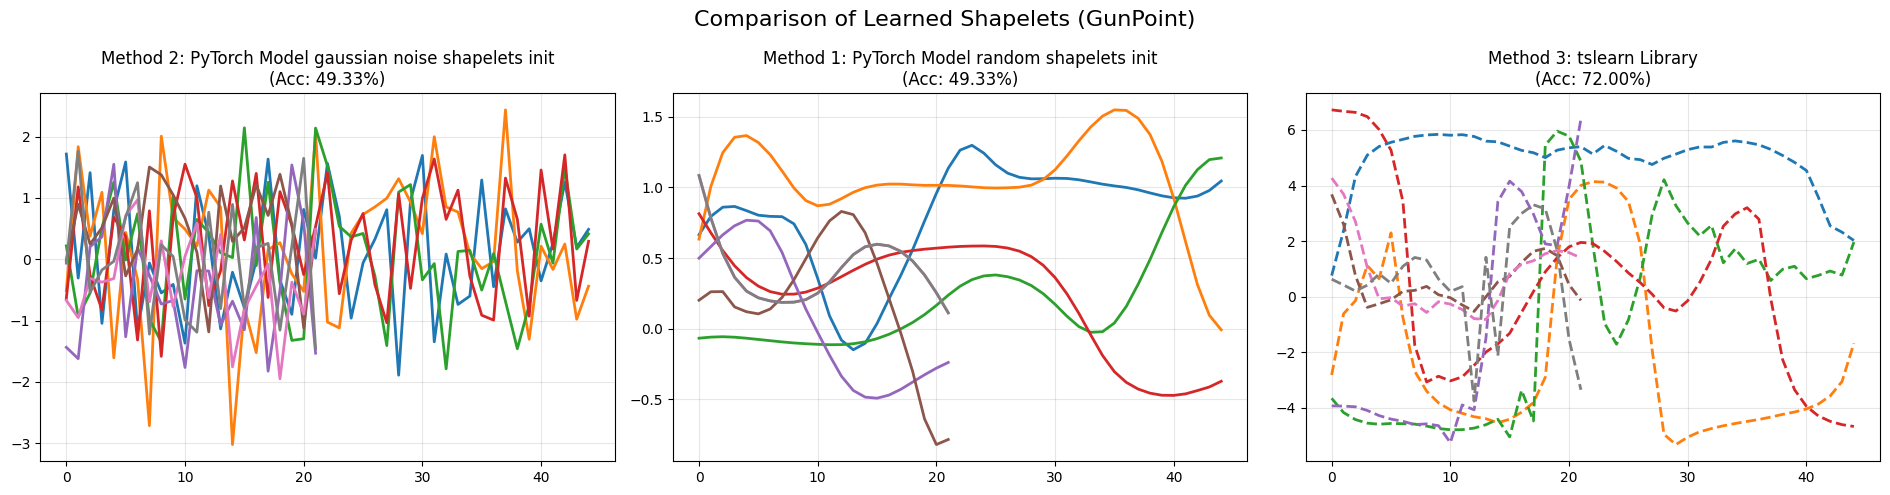

In [ ]:
# -----------------------------------------------------------------------------
# VISUALIZATION & COMPARISON
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(19, 5))

# Plot PyTorch
flat_shapelets_list = []
if isinstance(pt_shapelets, list):
    for block in pt_shapelets:
        # block is (N_sub, Length) -> iterate to get individual (Length,) arrays
        for shp in block:
            flat_shapelets_list.append(shp)
else:
    # Fallback for old single-block models
    flat_shapelets_list = list(pt_shapelets)

# 2. Convert to a single numpy array (dtype=object for jagged arrays)
pt_shapelets_concat = np.array(flat_shapelets_list, dtype=object)


# Plot PyTorch
flat_shapelets_list_noise = []
if isinstance(pt_shapelets_noise, list):
    for block in pt_shapelets_noise:
        # block is (N_sub, Length) -> iterate to get individual (Length,) arrays
        for shp in block:
            flat_shapelets_list_noise.append(shp)
else:
    # Fallback for old single-block models
    flat_shapelets_list_noise = list(pt_shapelets_noise)

# 2. Convert to a single numpy array (dtype=object for jagged arrays)
pt_shapelets_concat_noise = np.array(flat_shapelets_list_noise, dtype=object)

for i in range(len(pt_shapelets_concat)):
    # We access the i-th shapelet from the flat array
    axes[1].plot(pt_shapelets_concat[i], linewidth=2, label=f'Shp {i+1}')
axes[1].set_title(f'Method 1: PyTorch Model random shapelets init\n(Acc: {pt_acc:.2%})')
axes[1].grid(True, alpha=0.3)

for i in range(len(pt_shapelets_concat_noise)):
    # We access the i-th shapelet from the flat array
    axes[0].plot(pt_shapelets_concat_noise[i], linewidth=2, label=f'Shp {i+1}')
axes[0].set_title(f'Method 2: PyTorch Model gaussian noise shapelets init\n(Acc: {pt_acc:.2%})')
axes[0].grid(True, alpha=0.3)

# Plot tslearn
for i in range(len(ts_shapelets)):
    axes[2].plot(ts_shapelets[i], linewidth=2, linestyle='--', label=f'Shp {i+1}')
axes[2].set_title(f'Method 3: tslearn Library\n(Acc: {ts_acc:.2%})')
axes[2].grid(True, alpha=0.3)

plt.suptitle(f"Comparison of Learned Shapelets ({meta['dataset']})", fontsize=16)
plt.tight_layout()
plt.show()

### 4. Shapelet Interpretability

We visualize where specific learned shapelets "fire" (match) on the raw time series to verify they correspond to physical features (e.g., the hand recoil).

In [120]:
def plot_shapelet_on_series(series, shapelets_dict, shapelet_index=0, title="Shapelet Analysis"):
    """
    Plots the best matching position of a specific shapelet (by index) 
    for multiple methods (provided in shapelets_dict) on the same series.
    
    Args:
        series (array): The time series data (1D).
        shapelets_dict (dict): Keys are method names (str), Values are arrays of shapelets.
                               e.g., {'tslearn': all_ts_shapelets, 'pytorch': all_pt_shapelets}
        shapelet_index (int): Which shapelet from the array to visualize (default 0).
    """
    series = series.ravel()
    n_methods = len(shapelets_dict)
    
    # Create subplots: 1 row per method
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, 4 * n_methods), sharex=True)
    
    # Handle single-method case (axes is not a list if n=1)
    if n_methods == 1:
        axes = [axes]
        
    fig.suptitle(f"{title} - Comparing Shapelet #{shapelet_index+1}", fontsize=16)

    # Iterate over each method in the dictionary
    for ax, (method_name, shapelet_set) in zip(axes, shapelets_dict.items()):
        
        # 1. Select the specific shapelet
        # Check if shapelet_set is 2D (K shapelets) or 1D (single shapelet)
        shapelet_set = np.array(shapelet_set)
        if isinstance(shapelet_set, (np.ndarray, list)):
            current_shapelet = shapelet_set[shapelet_index]
        else:
            current_shapelet = shapelet_set
            
        current_shapelet = current_shapelet.ravel()
        
        # 2. Find Best Match (Sliding Window)
        n_series = len(series)
        n_shapelet = len(current_shapelet)
        if n_shapelet > n_series:
            print(f"Warning: Shapelet ({n_shapelet}) longer than series ({n_series}) for {method_name}")
            continue

        distances = []
        # Calculate Euclidean distance at every possible start point
        for i in range(n_series - n_shapelet + 1):
            window = series[i : i + n_shapelet]
            dist = np.linalg.norm(window - current_shapelet)
            distances.append(dist)
            
        best_idx = np.argmin(distances)
        min_dist = distances[best_idx]
        
        # 3. Plotting
        # A. Plot full series
        ax.plot(series, color='black', alpha=0.5, linewidth=1, label="Time Series")
        
        # B. Plot the shapelet overlay
        t_range = np.arange(best_idx, best_idx + n_shapelet)
        ax.plot(t_range, current_shapelet, color='tab:red', linewidth=3, label=f"{method_name} Shapelet")
        
        # C. Highlight the matching window
        ax.axvspan(best_idx, best_idx + n_shapelet, color='tab:red', alpha=0.15)
        
        # Formatting
        ax.set_title(f"Method: {method_name} (Dist: {min_dist:.4f})")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Amplitude")

    plt.xlabel("Time Step")
    plt.tight_layout()
    plt.show()


def plot_all_shapelets_grid(series, shapelets_dict, title="Shapelet Match Analysis"):
    """
    Plots a grid of matches: 
    - Rows: Different Methods (PyTorch, tslearn)
    - Cols: Individual Shapelets (1..K)
    """
    series = series.ravel()
    
    n_methods = len(shapelets_dict)
    # Determine K (number of shapelets) from the first method in the dict
    first_key = list(shapelets_dict.keys())[0]
    n_shapelets = shapelets_dict[first_key].shape[0]
    
    # Create Grid
    fig, axes = plt.subplots(n_methods, n_shapelets, 
                             figsize=(n_shapelets * 3, n_methods * 2.5), 
                             sharex=True, sharey=True)
    
    # Ensure axes is always 2D array [row, col] for consistent indexing
    if n_methods == 1 and n_shapelets == 1:
        axes = np.array([[axes]])
    elif n_methods == 1:
        axes = axes[np.newaxis, :] # 1 row, multiple cols
    elif n_shapelets == 1:
        axes = axes[:, np.newaxis] # Multiple rows, 1 col
        
    fig.suptitle(f"{title}\n(Red Region = Best Match Location)", fontsize=16, y=1.02)

    # Iterate Rows (Methods)
    for row_idx, (method_name, shapelets) in enumerate(shapelets_dict.items()):
        
        # Iterate Cols (Individual Shapelets)
        for col_idx in range(n_shapelets):
            ax = axes[row_idx, col_idx]
            shapelet = shapelets[col_idx].ravel()
            
            # --- 1. Find Best Match Logic ---
            n_series = len(series)
            n_shp = len(shapelet)
            
            distances = []
            for i in range(n_series - n_shp + 1):
                window = series[i : i + n_shp]
                dist = np.linalg.norm(window - shapelet)
                distances.append(dist)
            
            if len(distances) > 0:
                best_idx = np.argmin(distances)
            else:
                best_idx = 0

            # --- 2. Plotting ---
            # Grey background series
            ax.plot(series, color='gray', alpha=0.3, linewidth=1)
            
            # Red shapelet overlay
            t_range = np.arange(best_idx, best_idx + n_shp)
            ax.plot(t_range, shapelet, color='red', linewidth=2)
            
            # ADDED: Vertical Span Highlight
            ax.axvspan(best_idx, best_idx + n_shp, color='red', alpha=0.1)
            
            # Visuals
            if col_idx == 0:
                ax.set_ylabel(f"{method_name}", fontsize=12, fontweight='bold')
            
            if row_idx == 0:
                ax.set_title(f"Shapelet {col_idx+1}", fontsize=10)
                
            ax.grid(True, alpha=0.1)

    plt.tight_layout()
    plt.show()

#### Execution

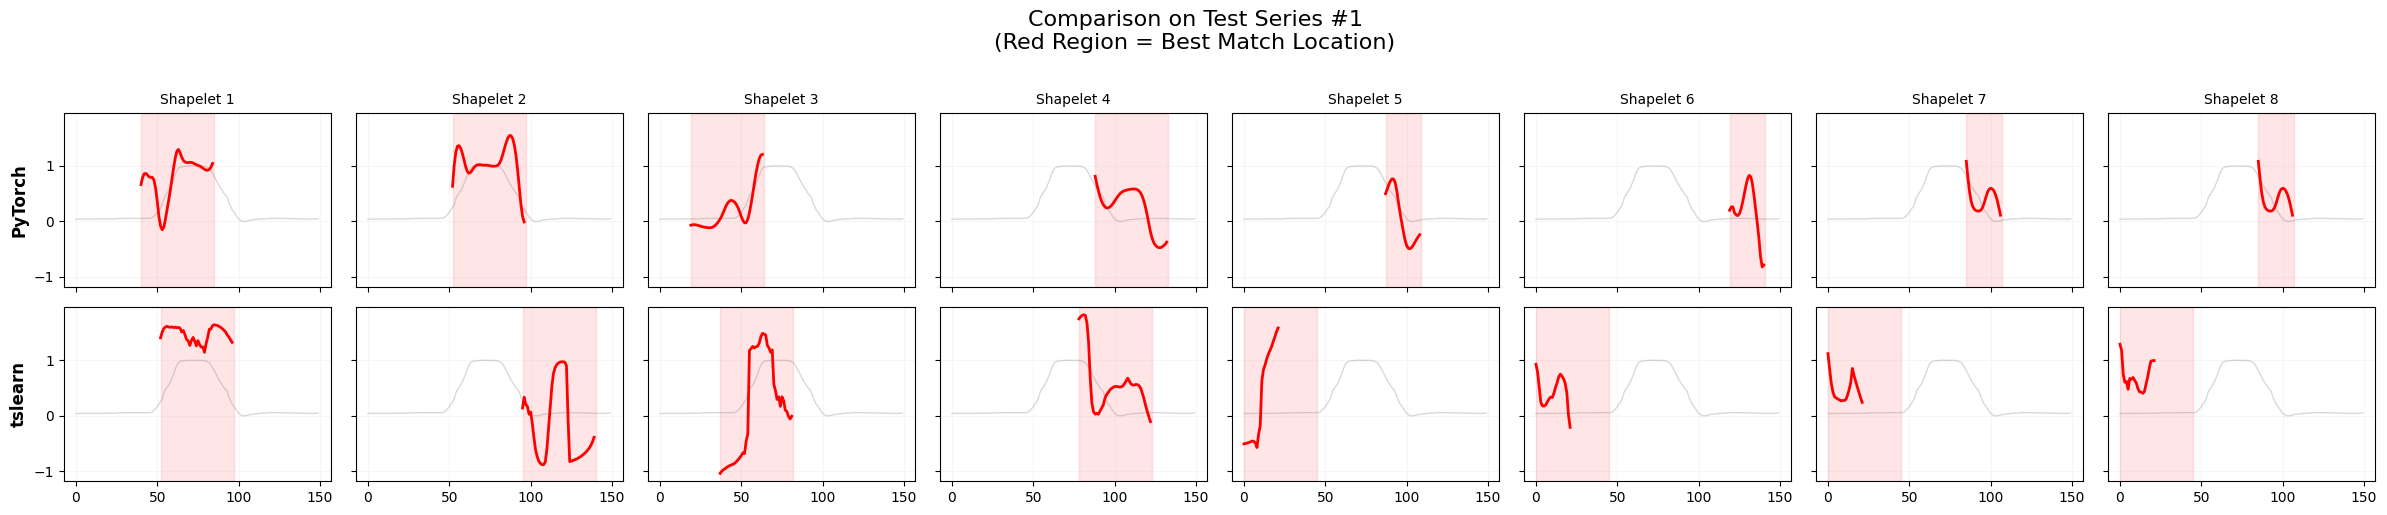

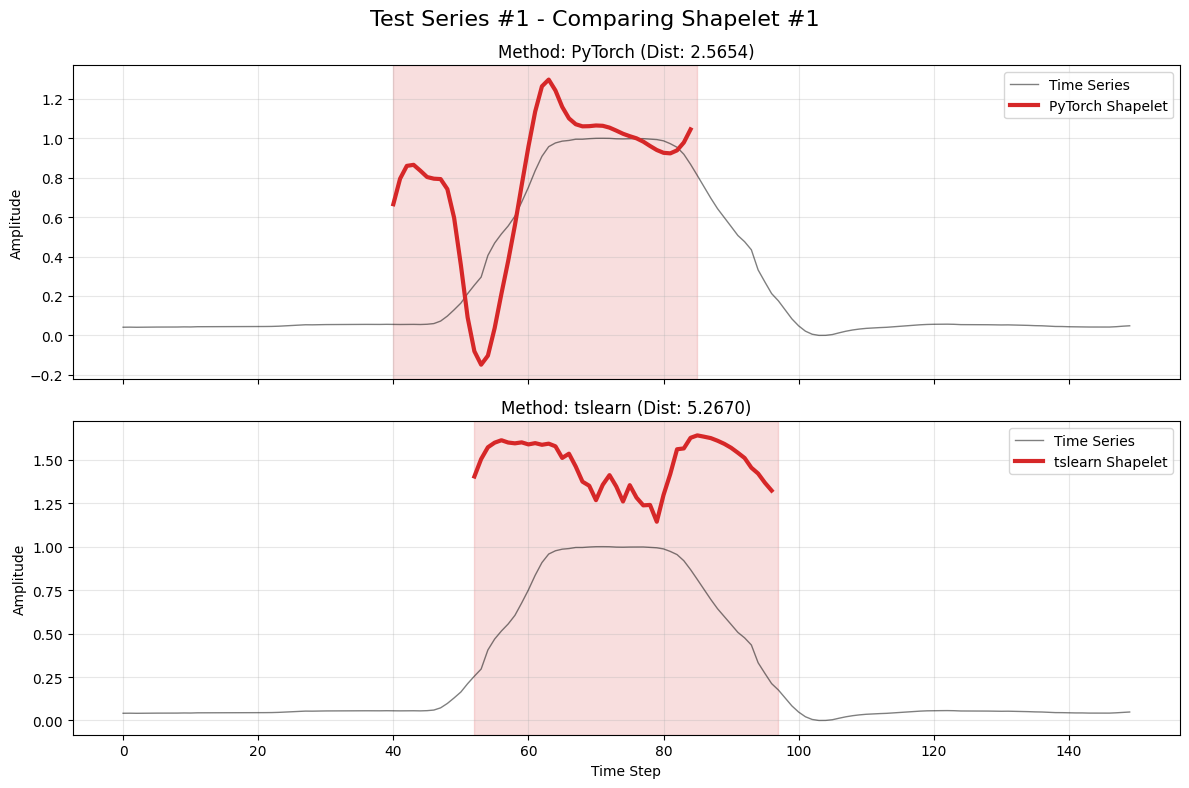

In [ ]:
# Pick a random test series
sample_id = np.random.randint(0, X_test.shape[0])
series_data = X_test[sample_id]

# Define dictionary
shapelets_dict = {
    'PyTorch': pt_shapelets_concat, # Shape: (K, L)
    'tslearn': ts_shapelets  # Shape: (K, L)
}

plot_all_shapelets_grid(series_data, shapelets_dict, title=f"Comparison on Test Series #{sample_id}")


# Visualize Shapelet at index 0 (First shapelet) for both models
plot_shapelet_on_series(series_data, shapelets_dict, shapelet_index=0, title=f"Test Series #{sample_id}")

## Part D: Diagnostics & Sensitivity Analysis

Here we perform rigorous Grid Searches to validate our architectural choices. We analyze the "Vanishing Gradient" problem and the stability of the model under varying hyperparameters.

### Experiment 1: The Impact of Alpha (α)

We sweep α from −1 to −500.

Hypothesis: A "Goldilocks zone" exists around −100. Low α results in blurry averages; extremely high α causes gradient instability.

Running Alpha Sensitivity Analysis...
Testing Alpha = -1.0...
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.6975
Iter 100: Loss = 0.6357
Iter 200: Loss = 0.4453
Iter 300: Loss = 0.3599
Iter 400: Loss = 0.3193
Iter 500: Loss = 0.2927
Iter 600: Loss = 0.2755
Iter 700: Loss = 0.2617
Iter 800: Loss = 0.2503
Iter 900: Loss = 0.2412
Iter 1000: Loss = 0.2330
Iter 1100: Loss = 0.2263
Iter 1200: Loss = 0.2203
Iter 1300: Loss = 0.2150
Iter 1400: Loss = 0.2102
Iter 1500: Loss = 0.2059
Iter 1600: Loss = 0.2020
Iter 1700: Loss = 0.1984
Iter 1800: Loss = 0.1952
Iter 1900: Loss = 0.1921
Iter 2000: Loss = 0.1895
Iter 2100: Loss = 0.1870
Iter 2200: Loss = 0.1850
Iter 2300: Loss = 0.1828
Iter 2400: Loss = 0.1811
Training Complete.
Testing Alpha = -2.0...
Training PyTorch Model (AdamW) for 2500 iterations...
Co

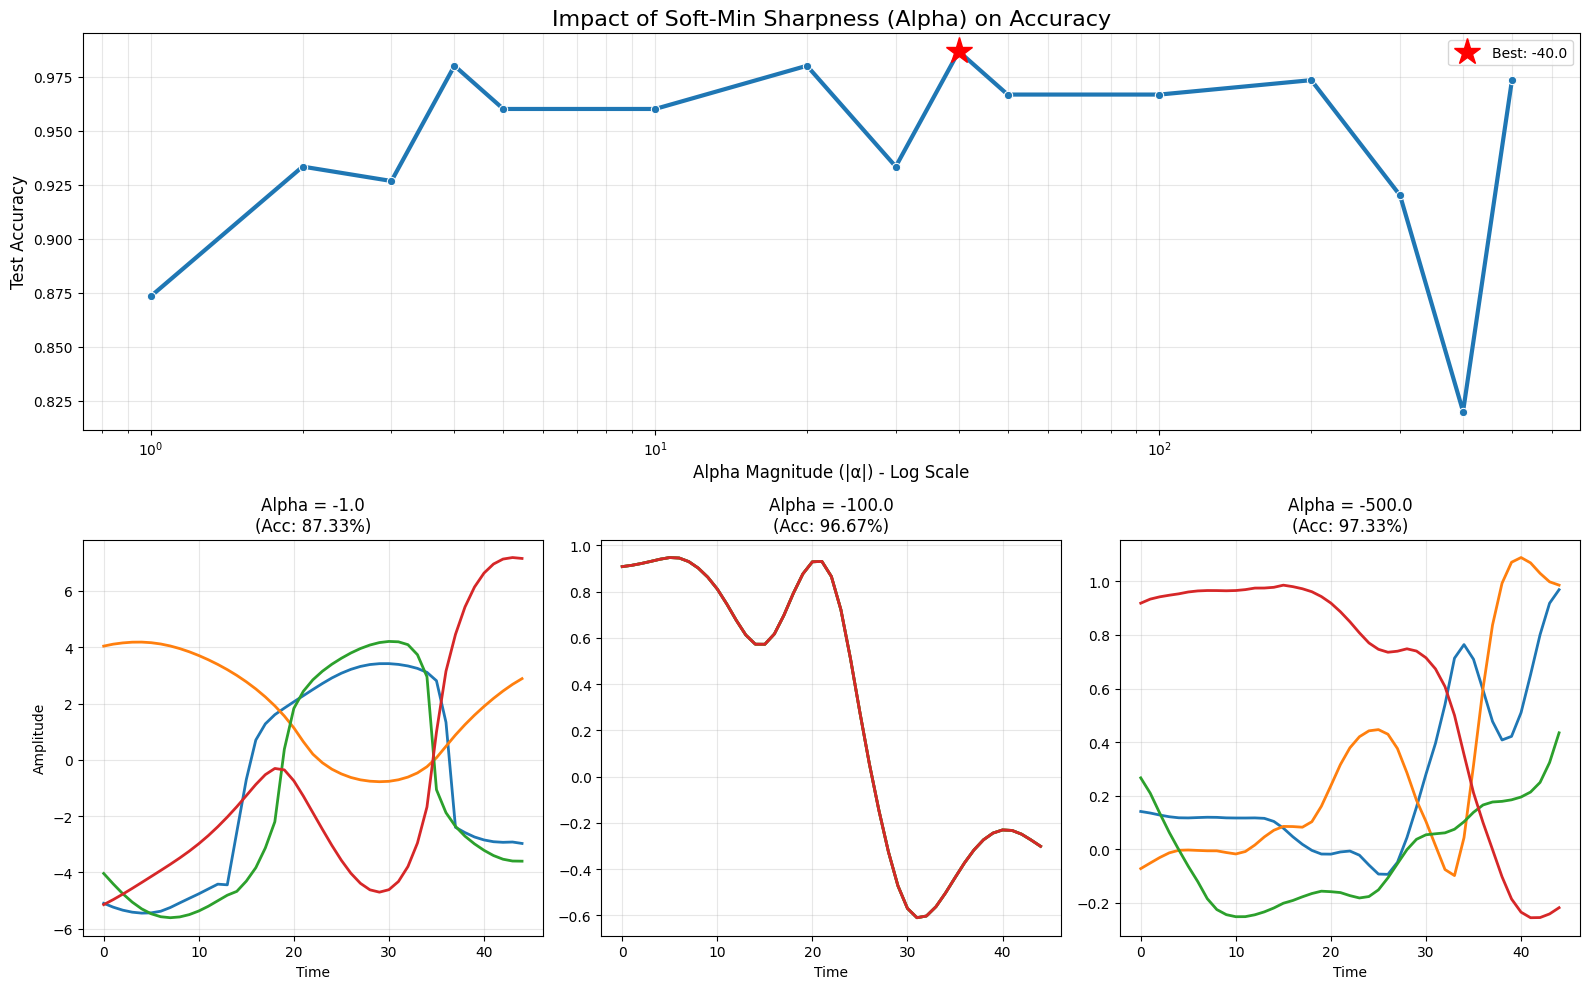

In [ ]:
# -----------------------------------------------------------------------------
# EXPERIMENT 1: ALPHA SENSITIVITY
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 1. SETUP THE EXPERIMENT
# -----------------------------------------------------------------------------
# We fix everything else and only vary Alpha
param_grid = {
    'ITERATIONS': [2500],            # Fixed
    'OPTIMIZER_NAME': ['AdamW'],    # Fixed
    'LR': [0.01],                   # Fixed
    'LAMBDA_W': [0.01],             # Fixed
    'INIT_MODE': ['random'],        # Fixed
    'shapelets_dict': [{45: 4}],    # Fixed config (e.g., 4 shapelets of len 30)
    
    # THE VARIABLE OF INTEREST
    # We span from very soft (-1) to very hard (-500)
    'ALPHA': [-1.0, -2.0, -3.0, -4.0, -5.0, -10.0, -20.0, -30.0, -40.0, -50.0, -100.0, -200.0, -300.0, -400.0, -500.0] 
}

# -----------------------------------------------------------------------------
# 2. RUN SEARCH (Modified to save all shapelets)
# -----------------------------------------------------------------------------
print("Running Alpha Sensitivity Analysis...")
grid_results = []

# Manual loop to ensure we keep the shapelets for plotting
for alpha in param_grid['ALPHA']:
    # Construct config for this run
    config = {
        'meta': meta,
        'ITERATIONS': param_grid['ITERATIONS'][0],
        'OPTIMIZER_NAME': param_grid['OPTIMIZER_NAME'][0],
        'LR': param_grid['LR'][0],
        'LAMBDA_W': param_grid['LAMBDA_W'][0],
        'INIT_MODE': param_grid['INIT_MODE'][0],
        'shapelets_dict': param_grid['shapelets_dict'][0],
        'ALPHA': alpha
    }
    
    print(f"Testing Alpha = {alpha}...")
    
    # Train
    run_out = pt_model_training(X_train, y_train, config)
    pt_model = run_out['model']
    
    # Evaluate
    pt_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.squeeze(), dtype=torch.float32)
        if X_test_tensor.ndim == 1: X_test_tensor = X_test_tensor.unsqueeze(1)
        
        logits, _ = pt_model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == torch.tensor(y_test, dtype=torch.long)).sum().item() / len(y_test)
    
    # Flatten shapelets for storage
    flat_shp = []
    for block in run_out['shapelets']:
        for shp in block:
            flat_shp.append(shp)
            
    grid_results.append({
        'alpha': alpha,
        'accuracy': acc,
        'shapelets': np.array(flat_shp, dtype=object)
    })

# Convert to DataFrame for easier plotting of metrics
df_alpha = pd.DataFrame(grid_results)

# -----------------------------------------------------------------------------
# 3. VISUALIZATION
# -----------------------------------------------------------------------------
df_alpha['alpha_abs'] = df_alpha['alpha'].abs()

# ... setup figure ...
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3)
ax_acc = fig.add_subplot(gs[0, :])

# 2. CHANGE X to 'alpha_abs' (the positive version)
sns.lineplot(data=df_alpha, x='alpha_abs', y='accuracy', marker='o', linewidth=3, ax=ax_acc, color='tab:blue')

ax_acc.set_title(f"Impact of Soft-Min Sharpness (Alpha) on Accuracy", fontsize=16)
ax_acc.set_ylabel("Test Accuracy", fontsize=12)

# 3. Log Scale now works because x is positive
ax_acc.set_xscale('log')
ax_acc.set_xlabel("Alpha Magnitude (|α|) - Log Scale", fontsize=12)
ax_acc.grid(True, which="both", alpha=0.3)

# 4. Fix the "Best Point" plotting to match the new X-axis
best_row = df_alpha.loc[df_alpha['accuracy'].idxmax()]
# Use best_row['alpha_abs'] for X, not best_row['alpha']
ax_acc.plot(best_row['alpha_abs'], best_row['accuracy'], 'r*', markersize=20, label=f"Best: {best_row['alpha']}")

ax_acc.legend()

# --- PLOT B: SHAPELET COMPARISONS ---
# We pick 3 representative runs to plot: Low, Medium, High magnitude
alpha_samples = [param_grid['ALPHA'][0], -100.0, param_grid['ALPHA'][-1]] 
# e.g., -1, -100, -500

# Subplot locations for the bottom row
subplots_locs = [gs[1, 0], gs[1, 1], gs[1, 2]]

for i, target_alpha in enumerate(alpha_samples):
    # Find the result for this alpha
    row = df_alpha[df_alpha['alpha'] == target_alpha].iloc[0]
    shapelets = row['shapelets']
    acc = row['accuracy']
    
    ax = fig.add_subplot(subplots_locs[i])
    for j, shp in enumerate(shapelets):
        ax.plot(shp, linewidth=2, label=f'Shp {j+1}')
        
    ax.set_title(f"Alpha = {target_alpha}\n(Acc: {acc:.2%})")
    ax.grid(True, alpha=0.3)
    if i == 0: ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()

### Experiment 2: Learning Rate Sensitivity

We analyze the behavior of AdamW across logarithmic scales of Learning Rate.

Hypothesis: Extremely high LR will cause artifacting (square waves), while low LR results in underfitting.

Running Learning Rate Sensitivity Analysis...
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.6945
Iter 100: Loss = 0.6926
Iter 200: Loss = 0.6907
Iter 300: Loss = 0.6890
Iter 400: Loss = 0.6873
Iter 500: Loss = 0.6857
Iter 600: Loss = 0.6841
Iter 700: Loss = 0.6826
Iter 800: Loss = 0.6811
Iter 900: Loss = 0.6795
Iter 1000: Loss = 0.6779
Iter 1100: Loss = 0.6758
Iter 1200: Loss = 0.6723
Iter 1300: Loss = 0.6693
Iter 1400: Loss = 0.6670
Iter 1500: Loss = 0.6649
Iter 1600: Loss = 0.6629
Iter 1700: Loss = 0.6610
Iter 1800: Loss = 0.6590
Iter 1900: Loss = 0.6572
Iter 2000: Loss = 0.6555
Iter 2100: Loss = 0.6540
Iter 2200: Loss = 0.6527
Iter 2300: Loss = 0.6513
Iter 2400: Loss = 0.6500
Training Complete.
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {45: 4} (Total K=4)
Initialization

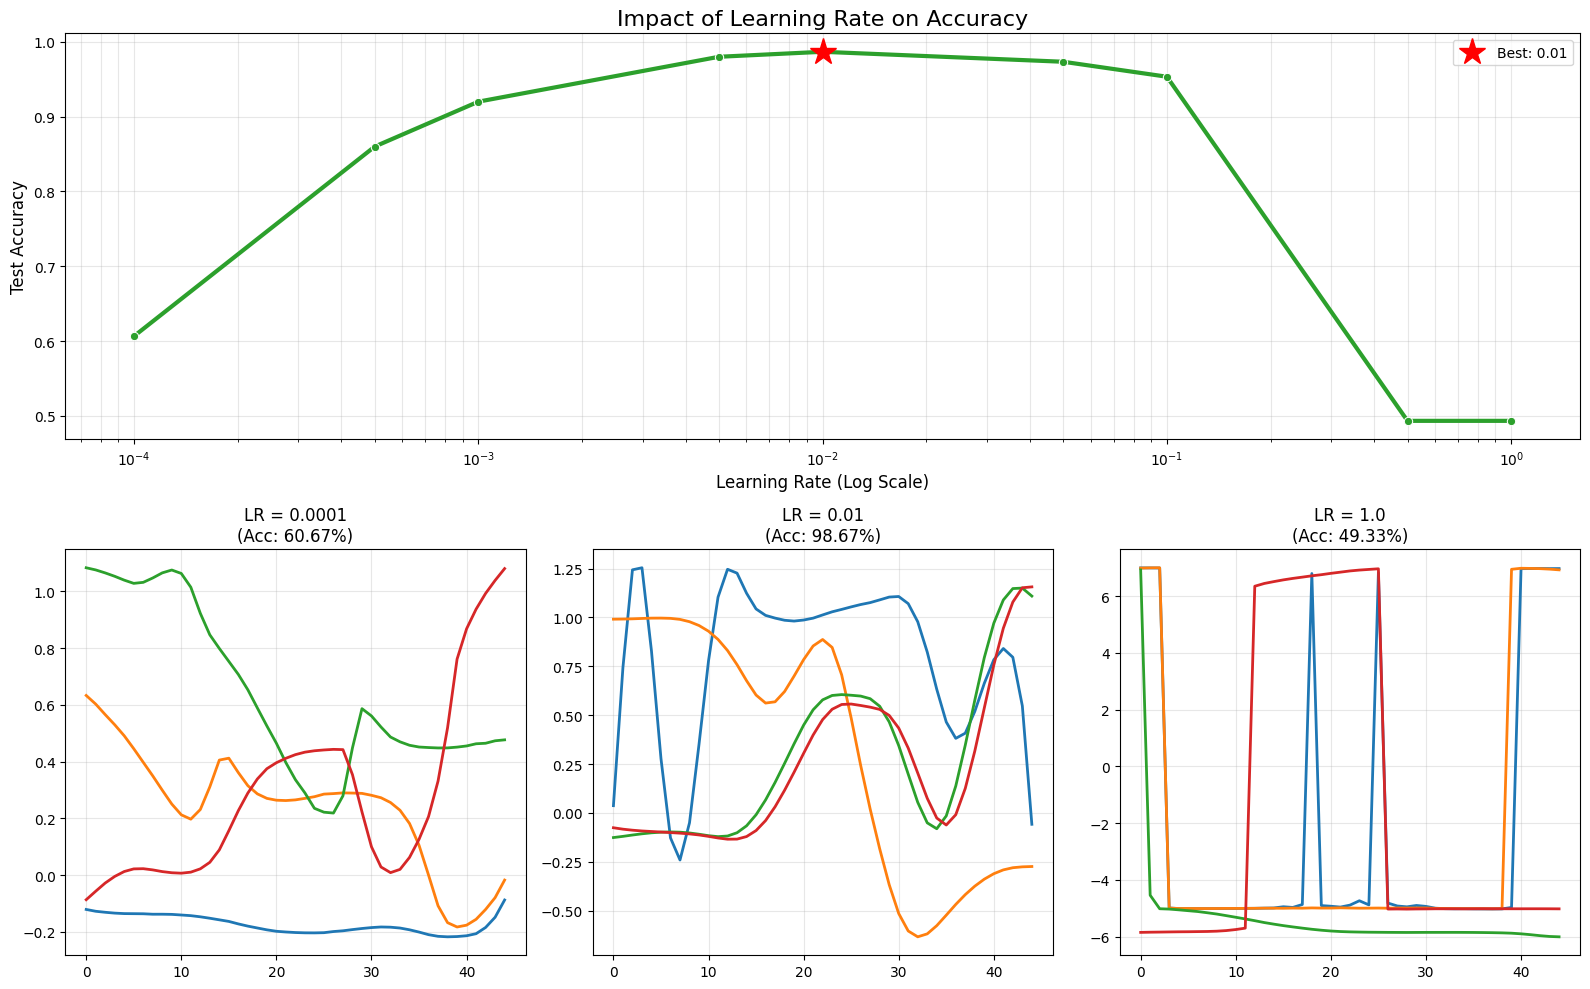

In [ ]:
# -----------------------------------------------------------------------------
# EXPERIMENT 2: LEARNING RATE SENSITIVITY
# -----------------------------------------------------------------------------
# Fix Alpha to your best value (e.g., -100 or -40)
BEST_ALPHA = -100.0 

param_grid_lr = {
    'ITERATIONS': [2500],
    'OPTIMIZER_NAME': ['AdamW'],
    'LAMBDA_W': [0.01],         # Fixed
    'INIT_MODE': ['random'],    # Fixed
    'shapelets_dict': [{45: 4}], 
    'ALPHA': [BEST_ALPHA],      # Fixed
    
    # VARIABLE: Learning Rate (Log scale sweep)
    'LR': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
}

print("Running Learning Rate Sensitivity Analysis...")
lr_results = []

for lr in param_grid_lr['LR']:
    config = {
        'meta': meta,
        'ITERATIONS': param_grid_lr['ITERATIONS'][0],
        'OPTIMIZER_NAME': param_grid_lr['OPTIMIZER_NAME'][0],
        'LAMBDA_W': param_grid_lr['LAMBDA_W'][0],
        'INIT_MODE': param_grid_lr['INIT_MODE'][0],
        'shapelets_dict': param_grid_lr['shapelets_dict'][0],
        'ALPHA': param_grid_lr['ALPHA'][0],
        'LR': lr
    }
    
    # Train
    run_out = pt_model_training(X_train, y_train, config)
    pt_model = run_out['model']
    
    # Evaluate
    pt_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.squeeze(), dtype=torch.float32)
        if X_test_tensor.ndim == 1: X_test_tensor = X_test_tensor.unsqueeze(1)
        logits, _ = pt_model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == torch.tensor(y_test, dtype=torch.long)).sum().item() / len(y_test)
    
    # Store
    flat_shp = []
    for block in run_out['shapelets']:
        for shp in block:
            flat_shp.append(shp)
            
    lr_results.append({
        'lr': lr,
        'accuracy': acc,
        'shapelets': np.array(flat_shp, dtype=object)
    })

df_lr = pd.DataFrame(lr_results)

# --- VISUALIZATION (LR) ---
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3)

# 1. Accuracy Plot
ax_acc = fig.add_subplot(gs[0, :])
sns.lineplot(data=df_lr, x='lr', y='accuracy', marker='o', linewidth=3, ax=ax_acc, color='tab:green')
ax_acc.set_xscale('log') # Log scale is crucial for LR
ax_acc.set_title("Impact of Learning Rate on Accuracy", fontsize=16)
ax_acc.set_xlabel("Learning Rate (Log Scale)", fontsize=12)
ax_acc.set_ylabel("Test Accuracy", fontsize=12)
ax_acc.grid(True, which="both", alpha=0.3)

# Mark Best
best_row = df_lr.loc[df_lr['accuracy'].idxmax()]
ax_acc.plot(best_row['lr'], best_row['accuracy'], 'r*', markersize=20, label=f"Best: {best_row['lr']}")
ax_acc.legend()

# 2. Shapelet Comparison (Low, Medium, High)
# Pick 3 indices: First (Low), Middle (Opt), Last (High)
indices = [0, len(df_lr)//2, -1] 
subplots = [gs[1, 0], gs[1, 1], gs[1, 2]]

for i, idx in enumerate(indices):
    row = df_lr.iloc[idx]
    ax = fig.add_subplot(subplots[i])
    for j, shp in enumerate(row['shapelets']):
        ax.plot(shp, linewidth=2, label=f'Shp {j+1}')
    ax.set_title(f"LR = {row['lr']}\n(Acc: {row['accuracy']:.2%})")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Experiment 3: Regularization (λ_W)

We test our Selective Weight Decay strategy.

Hypothesis: We expect accuracy to remain stable even with moderate regularization because we are not penalizing the shapelet weights, only the classifier. Accuracy should only collapse when the classifier is completely suppressed (λ>0.1).

Running Lambda_W Sensitivity Analysis...
Training PyTorch Model (AdamW) for 1000 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.6966
Iter 100: Loss = 0.6026
Iter 200: Loss = 0.5212
Iter 300: Loss = 0.4629
Iter 400: Loss = 0.4179
Iter 500: Loss = 0.3822
Iter 600: Loss = 0.3533
Iter 700: Loss = 0.3296
Iter 800: Loss = 0.3095
Iter 900: Loss = 0.2816
Training Complete.
Training PyTorch Model (AdamW) for 1000 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.7141
Iter 100: Loss = 0.6007
Iter 200: Loss = 0.5305
Iter 300: Loss = 0.3581
Iter 400: Loss = 0.2861
Iter 500: Loss = 0.2350
Iter 600: Loss = 0.2009
Iter 700: Loss = 0.1758
Iter 800: Loss = 0.1559
Iter 900: Loss = 0.1396
Training Com

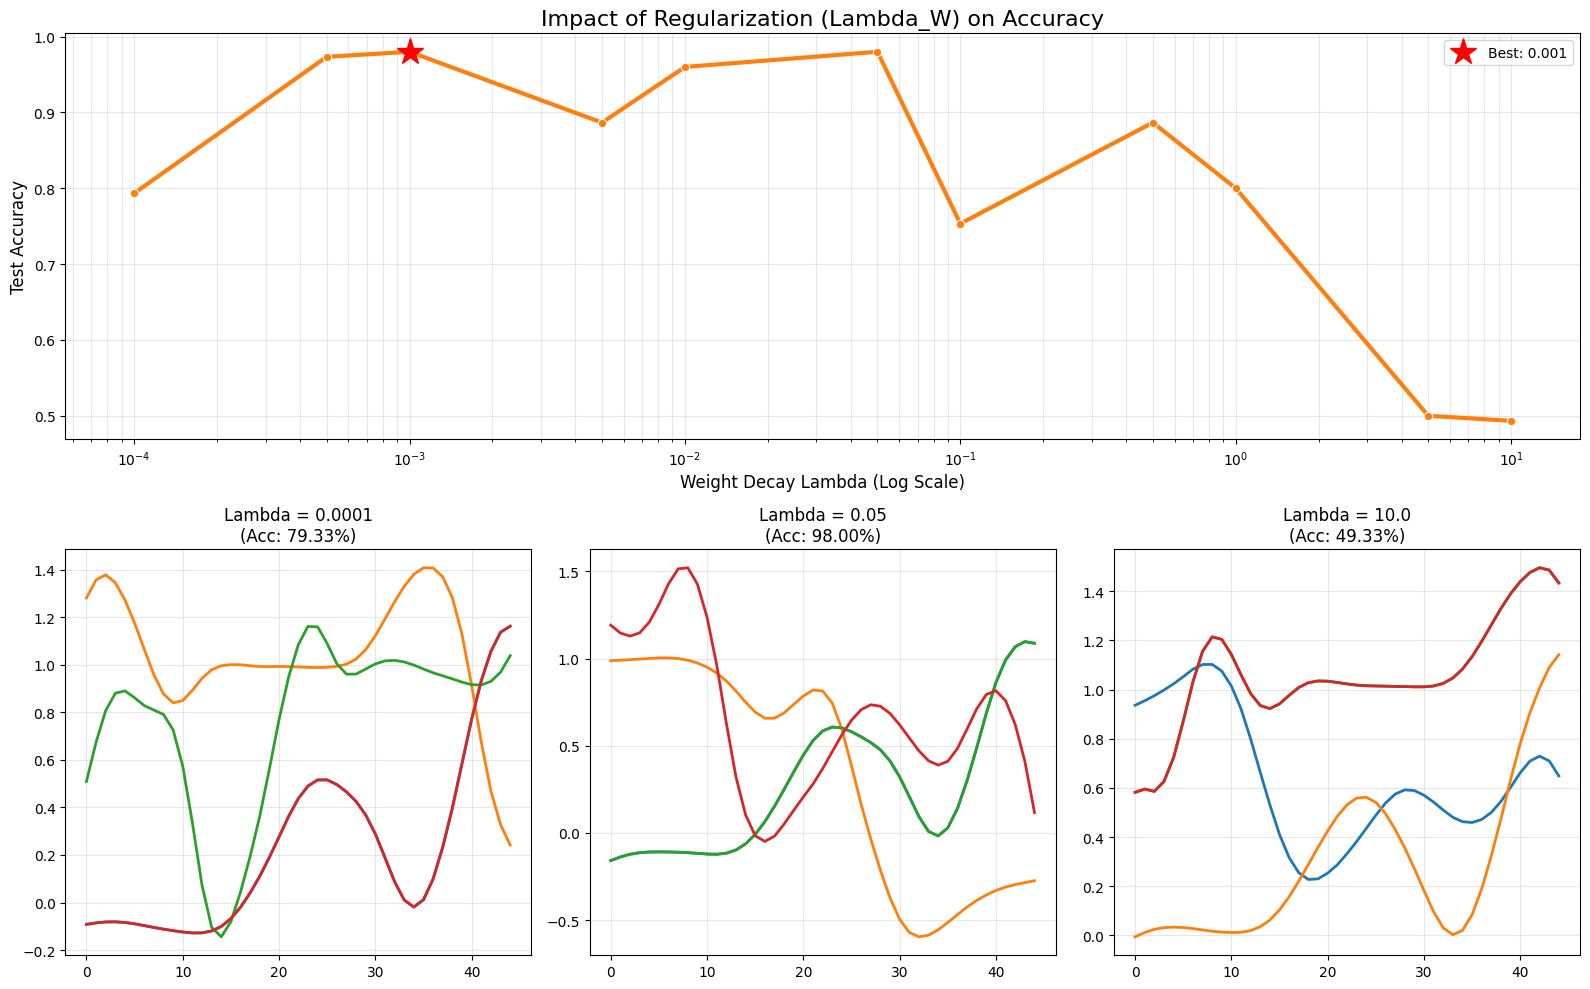

In [ ]:
# -----------------------------------------------------------------------------
# EXPERIMENT 3: REGULARIZATION (LAMBDA_W) SENSITIVITY
# -----------------------------------------------------------------------------
BEST_LR = 0.01
param_grid_reg = {
    'ITERATIONS': [1000],
    'OPTIMIZER_NAME': ['AdamW'],
    'LR': [BEST_LR],               # Fixed
    'INIT_MODE': ['random'],    # Fixed
    'shapelets_dict': [{45: 4}], 
    'ALPHA': [BEST_ALPHA],      # Fixed
    
    # VARIABLE: Lambda (Log scale sweep, including 0.0)
    'LAMBDA_W': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}

print("Running Lambda_W Sensitivity Analysis...")
reg_results = []

for lam in param_grid_reg['LAMBDA_W']:
    config = {
        'meta': meta,
        'ITERATIONS': param_grid_reg['ITERATIONS'][0],
        'OPTIMIZER_NAME': param_grid_reg['OPTIMIZER_NAME'][0],
        'LR': param_grid_reg['LR'][0],
        'INIT_MODE': param_grid_reg['INIT_MODE'][0],
        'shapelets_dict': param_grid_reg['shapelets_dict'][0],
        'ALPHA': param_grid_reg['ALPHA'][0],
        'LAMBDA_W': lam
    }
    
    # Train
    run_out = pt_model_training(X_train, y_train, config)
    pt_model = run_out['model']
    
    # Evaluate
    pt_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.squeeze(), dtype=torch.float32)
        if X_test_tensor.ndim == 1: X_test_tensor = X_test_tensor.unsqueeze(1)
        logits, _ = pt_model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == torch.tensor(y_test, dtype=torch.long)).sum().item() / len(y_test)
    
    # Store
    flat_shp = []
    for block in run_out['shapelets']:
        for shp in block:
            flat_shp.append(shp)
            
    reg_results.append({
        'lambda': lam,
        'accuracy': acc,
        'shapelets': np.array(flat_shp, dtype=object)
    })

df_reg = pd.DataFrame(reg_results)

# --- VISUALIZATION (Lambda) ---
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3)

# 1. Accuracy Plot
ax_acc = fig.add_subplot(gs[0, :])
# Handle 0.0 for log scale plotting by replacing it with a tiny number or just ignoring log for 0
df_plot = df_reg.copy()
df_plot.loc[df_plot['lambda'] == 0.0, 'lambda'] = 0.00001 # Small epsilon for plot

sns.lineplot(data=df_plot, x='lambda', y='accuracy', marker='o', linewidth=3, ax=ax_acc, color='tab:orange')
ax_acc.set_xscale('log')
ax_acc.set_title("Impact of Regularization (Lambda_W) on Accuracy", fontsize=16)
ax_acc.set_xlabel("Weight Decay Lambda (Log Scale)", fontsize=12)
ax_acc.set_ylabel("Test Accuracy", fontsize=12)
ax_acc.grid(True, which="both", alpha=0.3)

# Mark Best
best_row = df_reg.loc[df_reg['accuracy'].idxmax()]
best_val_plot = 0.00001 if best_row['lambda'] == 0.0 else best_row['lambda']
ax_acc.plot(best_val_plot, best_row['accuracy'], 'r*', markersize=20, label=f"Best: {best_row['lambda']}")
ax_acc.legend()

# 2. Shapelet Comparison
# Indices: 0 (No Reg), Middle (Moderate), Last (High Reg)
indices = [0, len(df_reg)//2, -1]
subplots = [gs[1, 0], gs[1, 1], gs[1, 2]]

for i, idx in enumerate(indices):
    row = df_reg.iloc[idx]
    ax = fig.add_subplot(subplots[i])
    for j, shp in enumerate(row['shapelets']):
        ax.plot(shp, linewidth=2, label=f'Shp {j+1}')
    ax.set_title(f"Lambda = {row['lambda']}\n(Acc: {row['accuracy']:.2%})")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part E: Multiclass Generalization (ElectricDevices)

To prove the robustness of the model, we move beyond simple binary classification to a complex dataset: ElectricDevices (7 classes).

This dataset characterizes electricity consumption profiles of various household appliances, featuring high intra-class variability and sharp, high-frequency signatures.

### 1. Data Loading & Visualization

Loading the 7-class dataset and visualizing the distinct "on/off" switching pattern

In [48]:
# -----------------------------------------------------------------------------
# DATA LOADING & PREPROCESSING
# -----------------------------------------------------------------------------

# Load Complex Dataset (e.g., ElectricDevices: 7 classes)
# Or "Trace" (4 classes), "Plane" (7 classes)
target_dataset = "ElectricDevices" 
print(f"Loading {target_dataset}...")

ucr = UCR_UEA_datasets()
try:
    X_train, y_train, X_test, y_test = ucr.load_dataset(target_dataset)
except:
    print("Download failed, falling back to cached GunPoint for demo...")
    X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

# Preprocessing
sc = TimeSeriesScalerMinMax()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Label Encoding (Ensure 0..C-1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(f"Data Loaded: Train={X_train.shape}, Test={X_test.shape}")
print(f"Classes: {len(np.unique(y_train))}")


Loading ElectricDevices...
Data Loaded: Train=(8926, 96, 1), Test=(7711, 96, 1)
Classes: 7


Plotting samples for dataset: ElectricDevices


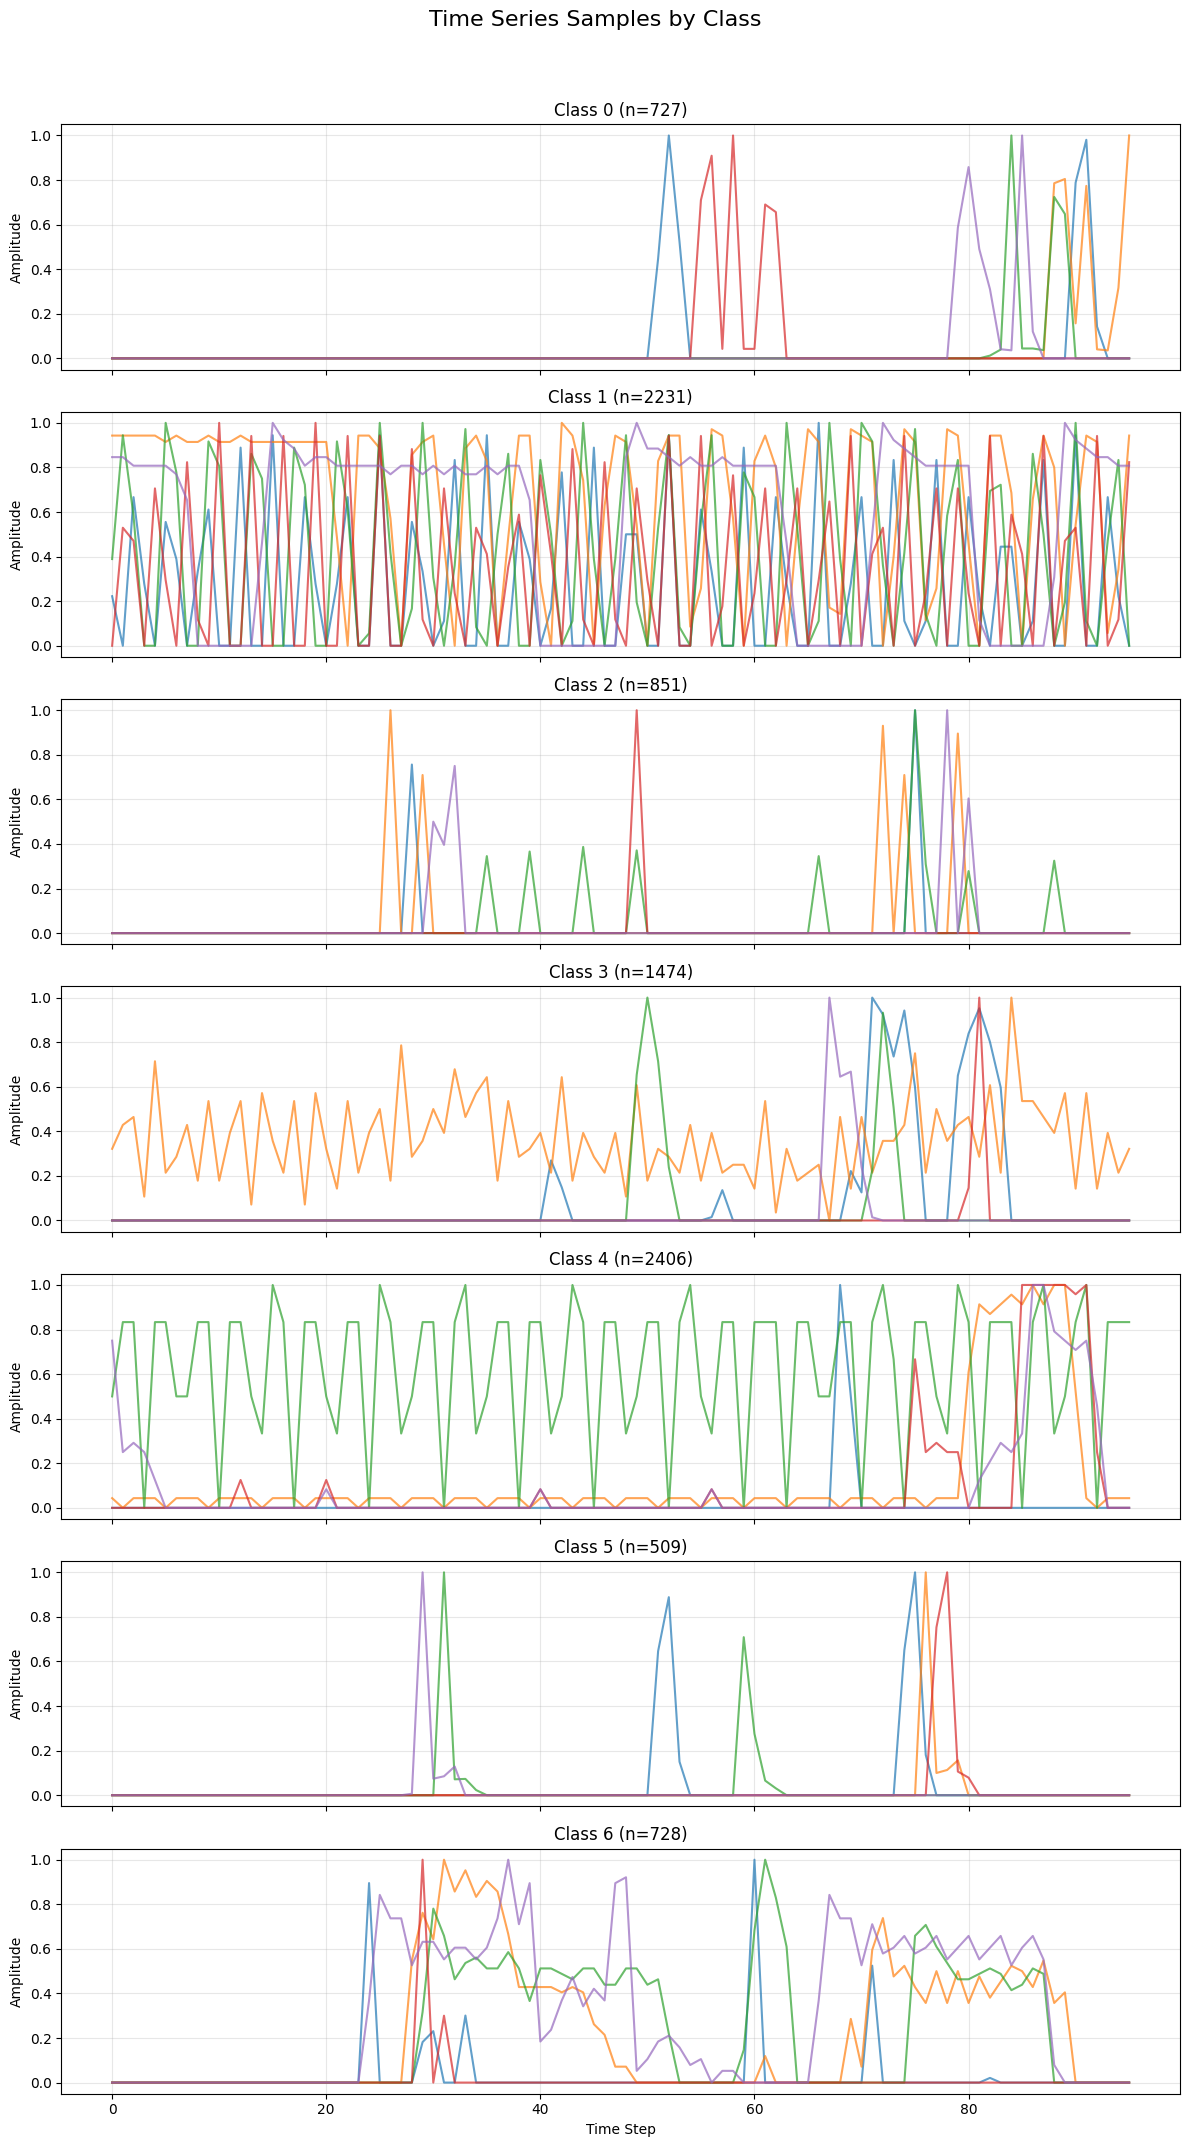

In [ ]:
def plot_dataset_samples(X, y, num_samples=3, title="Time Series Samples by Class"):
    """
    Plots a few random samples from each class in the dataset.
    """
    classes = np.unique(y)
    n_classes = len(classes)
    
    # Create a grid of subplots (one row per class)
    fig, axes = plt.subplots(n_classes, 1, figsize=(12, 3 * n_classes), sharex=True)
    if n_classes == 1: axes = [axes] # Handle single class edge case

    for i, cls in enumerate(classes):
        # Get all indices for this class
        idxs = np.where(y == cls)[0]
        
        # Select random samples
        selected_idxs = np.random.choice(idxs, min(num_samples, len(idxs)), replace=False)
        
        ax = axes[i]
        for idx in selected_idxs:
            # Handle potential 3D shape (N, T, 1) or 2D (N, T)
            series = X[idx].ravel() 
            ax.plot(series, alpha=0.7, linewidth=1.5)
            
        ax.set_title(f"Class {cls} (n={len(idxs)})")
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Amplitude")
        
        if i == n_classes - 1:
            ax.set_xlabel("Time Step")

    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

#### Visualization

In [ ]:
print(f"Plotting samples for dataset: {target_dataset}")
plot_dataset_samples(X_train, y_train, num_samples=5)

### 2. Baselines (1NN-DTW & Euclidean)

We calculate standard baselines using tslearn. 1NN-DTW is generally considered a strong benchmark for time series classification.

In [ ]:
# -----------------------------------------------------------------------------
# BASELINES (Your Code)
# -----------------------------------------------------------------------------
def fit_baselines_once(X_train, y_train, X_test, y_test):
    print("=== Baselines (fit once) ===")

    # Subsample for baselines if dataset is huge (DTW is O(N^2))
    if len(X_train) > 2000:
        print("Note: Subsampling baselines to 2000 samples for speed...")
        idx = np.random.choice(len(X_train), 2000, replace=False)
        X_train_sub, y_train_sub = X_train[idx], y_train[idx]
    else:
        X_train_sub, y_train_sub = X_train, y_train

    knn_euc = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
    # knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

    print("-> Fitting 1NN-Euclidean...")
    t0 = time.perf_counter()
    knn_euc.fit(X_train_sub, y_train_sub)
    fit_euc_s = time.perf_counter() - t0

    # print("-> Fitting 1NN-DTW (this might take a while)...")
    # t0 = time.perf_counter()
    # knn_dtw.fit(X_train_sub, y_train_sub)
    # fit_dtw_s = time.perf_counter() - t0

    print("-> Predicting Euclidean...")
    t0 = time.perf_counter()
    pred_euc = knn_euc.predict(X_test)
    pred_euc_s = time.perf_counter() - t0

    # print("-> Predicting DTW...")
    # t0 = time.perf_counter()
    # pred_dtw = knn_dtw.predict(X_test)
    # pred_dtw_s = time.perf_counter() - t0

    baselines = pd.DataFrame(
        [
            {
                "model": "1NN-euclidean",
                "test_acc": float(accuracy_score(y_test, pred_euc)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_euc)),
                "test_f1_macro": float(f1_score(y_test, pred_euc, average="macro")),
                "total_time_s": fit_euc_s + pred_euc_s,
            },
            # {
            #     "model": "1NN-dtw",
            #     "test_acc": float(accuracy_score(y_test, pred_dtw)),
            #     "test_bal_acc": float(balanced_accuracy_score(y_test, pred_dtw)),
            #     "test_f1_macro": float(f1_score(y_test, pred_dtw, average="macro")),
            #     "total_time_s": fit_dtw_s + pred_dtw_s,
            # },
        ]
    ).sort_values("test_acc", ascending=False)

    print(baselines.to_string(index=False))
    print()

    return baselines

In [ ]:
# Run Baselines
df_baselines = fit_baselines_once(X_train, y_train, X_test, y_test)

=== Baselines (fit once) ===
Note: Subsampling baselines to 2000 samples for speed...
-> Fitting 1NN-Euclidean...
-> Predicting Euclidean...
        model  test_acc  test_bal_acc  test_f1_macro  total_time_s
1NN-euclidean  0.456102      0.393844       0.393081      4.680782



### 3. PyTorch Grid Search

We run a grid search to find the optimal Shapelet configuration (Lengths and Counts) for this specific dataset.

In [ ]:
# -----------------------------------------------------------------------------
# PYTORCH GRID SEARCH (Updated for Comparison)
# -----------------------------------------------------------------------------
def pt_grid_search_pipeline(X_train, y_train, X_test, y_test, param_grid):
    grid = ParameterGrid(param_grid)
    results_list = []
    best_acc = -1.0
    best_run = None
    
    print(f"=== PyTorch Grid Search ({len(grid)} combinations) ===")
    
    meta_info = {
        'dataset': 'GridSearch',
        'n_classes': len(np.unique(y_train)),
        'ts_len': X_train.shape[1]
    }

    for i, params in enumerate(grid):
        print(f"Run {i+1}/{len(grid)} | Params: {params}")
        
        train_config = params.copy()
        train_config['meta'] = meta_info
        
        try:
            # 1. Train
            run_output = pt_model_training(X_train, y_train, train_config)
            
            # 2. Evaluate
            pt_model = run_output['model']
            pt_model.eval()
            
            with torch.no_grad():
                X_test_sq = X_test.squeeze()
                if X_test_sq.ndim == 1: X_test_sq = X_test_sq.unsqueeze(1)
                X_test_tensor = torch.tensor(X_test_sq, dtype=torch.float32)
                y_test_tensor = torch.tensor(y_test, dtype=torch.long)
                
                logits, _ = pt_model(X_test_tensor)
                preds = torch.argmax(logits, dim=1)
                
                # Metrics
                acc = accuracy_score(y_test, preds.cpu().numpy())
                bal_acc = balanced_accuracy_score(y_test, preds.cpu().numpy())
                f1 = f1_score(y_test, preds.cpu().numpy(), average="macro")
            
            print(f"   -> Test Acc: {acc:.4%} | Time: {run_output['time']:.2f}s")
            
            # 3. Store Result
            result_entry = params.copy()
            result_entry['shapelets_dict_str'] = str(params['shapelets_dict']) 
            result_entry['test_acc'] = acc
            result_entry['test_bal_acc'] = bal_acc
            result_entry['test_f1_macro'] = f1
            result_entry['total_time_s'] = run_output['time'] # Approximation (Train time dominates)
            results_list.append(result_entry)
            
            # 4. Track Best
            if acc > best_acc:
                best_acc = acc
                flat_shapelets = []
                for block in run_output['shapelets']:
                    for shp in block:
                        flat_shapelets.append(shp)

                best_run = {
                    'params': params,
                    'model': pt_model,
                    'test_acc': acc,
                    'shapelets': np.array(flat_shapelets, dtype=object),
                    'time': run_output['time']
                }
                
        except Exception as e:
            print(f"   -> Run Failed: {e}")
            import traceback
            traceback.print_exc()
            
    print("="*60)
    print(f"Grid Search Complete. Best Accuracy: {best_acc:.4%}")
    
    return pd.DataFrame(results_list), best_run


In [ ]:
# Run PyTorch Grid Search
# Fixing Lambda_W to 0.01, varying Shapelets and LR
ts_len = X_train.shape[1]

param_grid = {
    'ITERATIONS': [2000],
    'OPTIMIZER_NAME': ['AdamW'], 
    'LAMBDA_W': [0.01],           # Fixed as requested
    'ALPHA': [-100.0],            # Fixed sweet spot
    'INIT_MODE': ['random'],      # Strong initialization
    
    # GRID SEARCH PARAMETERS
    'LR': [0.05],      # Learning Rate Grid
    'shapelets_dict': [
        # Strategy 1: Short features (approx 10-20% of length)
        {int(ts_len*0.1): 8,  int(ts_len*0.2): 8},
        # Strategy 2: Medium features (approx 30% of length)
        {int(ts_len*0.3): 16},
        # Strategy 3: Multi-scale (Short, Medium, Long)
        {int(ts_len*0.3): 6, int(ts_len*0.2): 4, int(ts_len*0.1): 6},
    ]
}

df_grid, best_run = pt_grid_search_pipeline(X_train, y_train, X_test, y_test, param_grid)

=== PyTorch Grid Search (3 combinations) ===
Run 1/3 | Params: {'ALPHA': -100.0, 'INIT_MODE': 'random', 'ITERATIONS': 2000, 'LAMBDA_W': 0.01, 'LR': 0.05, 'OPTIMIZER_NAME': 'AdamW', 'shapelets_dict': {9: 8, 19: 8}}
Training PyTorch Model (AdamW) for 2000 iterations...
Config: {9: 8, 19: 8} (Total K=16)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GridSearch...
Iter 0: Loss = 1.9666
Iter 100: Loss = 1.0258
Iter 200: Loss = 0.8557
Iter 300: Loss = 0.7714
Iter 400: Loss = 0.7249
Iter 500: Loss = 0.6893
Iter 600: Loss = 0.6676
Iter 700: Loss = 0.6512
Iter 800: Loss = 0.6343
Iter 900: Loss = 0.6258
Iter 1000: Loss = 0.6150
Iter 1100: Loss = 0.7123
Iter 1200: Loss = 0.6376
Iter 1300: Loss = 0.6214
Iter 1400: Loss = 0.6119
Iter 1500: Loss = 0.6047
Iter 1600: Loss = 0.6049
Iter 1700: Loss = 0.5976
Iter 1800: Loss = 0.5931
Iter 1900: Loss = 0.5990
Training Complete.
   -> Test Acc: 65.4779% | Time: 675.76s
Run

#### 4. Final Results & Comparison

We compile the results into a table comparing our best PyTorch model against the baselines. We also visualize the shapelets to see how the model adapted to the high-frequency electronic signals.

In [ ]:
# -----------------------------------------------------------------------------
# VISUALIZATION FUNCTIONS
# -----------------------------------------------------------------------------

def plot_grid_search_heatmap(results_df, x_param, y_param, metric='accuracy'):
    """
    Plots a heatmap of accuracy for two parameters.
    """
    pivot_table = results_df.pivot_table(values=metric, index=y_param, columns=x_param)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
    plt.title(f"{metric.capitalize()} Heatmap: {y_param} vs {x_param}")
    plt.show()

def visualize_best_shapelets(best_run):
    acc = best_run['test_acc']
    shapelets = best_run['shapelets']
    params = best_run['params']
    
    plt.figure(figsize=(10, 5))
    for i, shp in enumerate(shapelets):
        plt.plot(shp, linewidth=2, label=f'Shp {i+1}')
    plt.title(f"Best Model Shapelets (Acc: {acc:.2%})\nParams: {params}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


FINAL STUDY RESULTS
          model  test_acc  test_bal_acc  test_f1_macro  total_time_s
ShapeNet (Best)  0.681624      0.569545       0.567561    957.331701
  1NN-euclidean  0.456102      0.393844       0.393081      4.680782


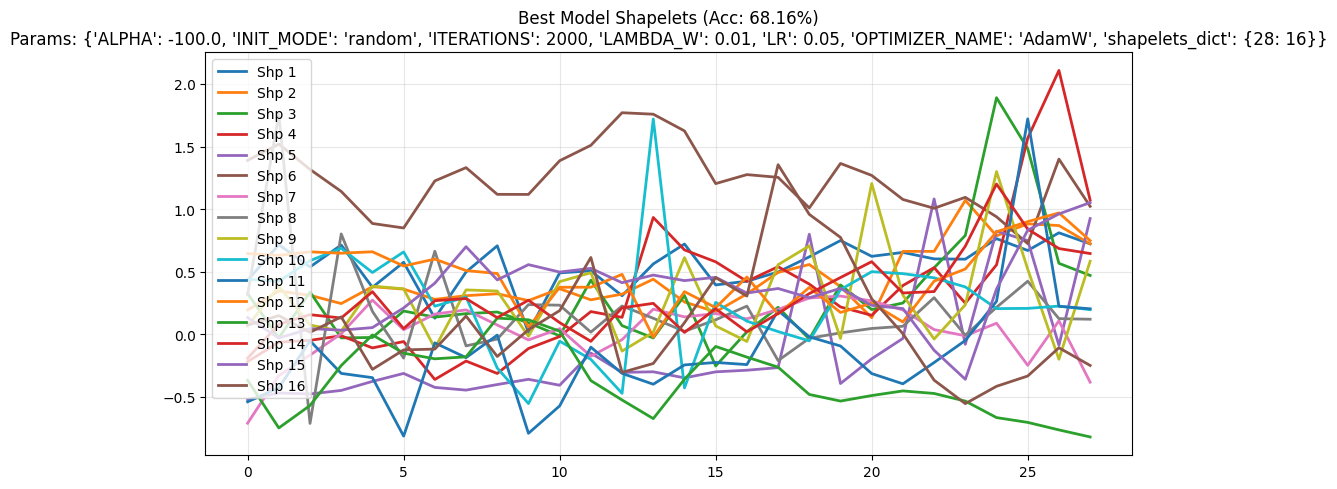

In [ ]:
# Final Comparison Table
# Extract best PyTorch result
best_pt_row = df_grid.loc[df_grid['test_acc'].idxmax()]

comparison_row = {
    "model": f"ShapeNet (Best)",
    "test_acc": best_pt_row['test_acc'],
    "test_bal_acc": best_pt_row['test_bal_acc'],
    "test_f1_macro": best_pt_row['test_f1_macro'],
    "total_time_s": best_pt_row['total_time_s']
}

# Combine
final_comparison = pd.concat([df_baselines, pd.DataFrame([comparison_row])], ignore_index=True)
final_comparison = final_comparison.sort_values("test_acc", ascending=False)

print("\n" + "="*30)
print("FINAL STUDY RESULTS")
print("="*30)
print(final_comparison.to_string(index=False))

# Optional: Plot Best Shapelets
if best_run:
    visualize_best_shapelets(best_run)

### Second Test

In [63]:
# C. Run PyTorch Grid Search
# Fixing Lambda_W to 0.01, varying Shapelets and LR
ts_len = X_train.shape[1]

param_grid = {
    'ITERATIONS': [2500],
    'OPTIMIZER_NAME': ['AdamW'], 
    'LAMBDA_W': [0.01],           # Fixed as requested
    'ALPHA': [-100.0],            # Fixed sweet spot
    'INIT_MODE': ['random'],      # Strong initialization
    
    # GRID SEARCH PARAMETERS
    'LR': [0.01],      # Learning Rate Grid
    'shapelets_dict': [
        # Strategy 1: Short features (approx 10-20% of length)
        {int(ts_len*0.1): 8,  int(ts_len*0.2): 8},
        # Strategy 2: Medium features (approx 30% of length)
        {int(ts_len*0.3): 16},
        # Strategy 3: Multi-scale (Short, Medium, Long)
        {int(ts_len*0.3): 6, int(ts_len*0.2): 4, int(ts_len*0.1): 6},
        {int(ts_len*0.3): 8, int(ts_len*0.2): 4, int(ts_len*0.1): 4},
        {int(ts_len*0.3): 10, int(ts_len*0.2): 4, int(ts_len*0.1): 2},
    ]
}

df_grid, best_run = pt_grid_search_pipeline(X_train, y_train, X_test, y_test, param_grid)

=== PyTorch Grid Search (5 combinations) ===
Run 1/5 | Params: {'ALPHA': -100.0, 'INIT_MODE': 'random', 'ITERATIONS': 2500, 'LAMBDA_W': 0.01, 'LR': 0.01, 'OPTIMIZER_NAME': 'AdamW', 'shapelets_dict': {9: 8, 19: 8}}
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {9: 8, 19: 8} (Total K=16)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GridSearch...
Iter 0: Loss = 1.9350
Iter 100: Loss = 1.4848
Iter 200: Loss = 1.3287
Iter 300: Loss = 1.2185
Iter 400: Loss = 1.1416
Iter 500: Loss = 1.0843
Iter 600: Loss = 1.0396
Iter 700: Loss = 1.0029
Iter 800: Loss = 0.9726
Iter 900: Loss = 0.9286
Iter 1000: Loss = 0.8890
Iter 1100: Loss = 0.8466
Iter 1200: Loss = 0.8177
Iter 1300: Loss = 0.7925
Iter 1400: Loss = 0.7722
Iter 1500: Loss = 0.7573
Iter 1600: Loss = 0.7422
Iter 1700: Loss = 0.7307
Iter 1800: Loss = 0.7178
Iter 1900: Loss = 0.7077
Iter 2000: Loss = 0.6987
Iter 2100: Loss = 0.6900
Iter 2200: Lo


FINAL STUDY RESULTS
          model  test_acc  test_bal_acc  test_f1_macro  total_time_s
ShapeNet (Best)  0.685255      0.576545       0.577478   1280.250604
  1NN-euclidean  0.456102      0.393844       0.393081      4.680782


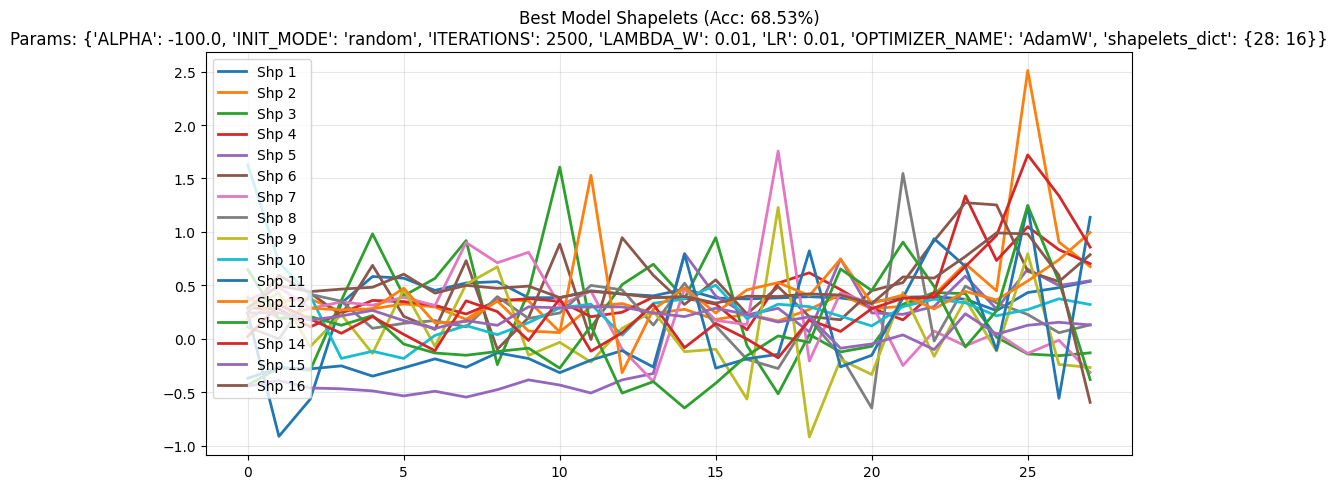

In [64]:
# D. Final Comparison Table
# Extract best PyTorch result
best_pt_row = df_grid.loc[df_grid['test_acc'].idxmax()]

comparison_row = {
    "model": f"ShapeNet (Best)",
    "test_acc": best_pt_row['test_acc'],
    "test_bal_acc": best_pt_row['test_bal_acc'],
    "test_f1_macro": best_pt_row['test_f1_macro'],
    "total_time_s": best_pt_row['total_time_s']
}

# Combine
final_comparison = pd.concat([df_baselines, pd.DataFrame([comparison_row])], ignore_index=True)
final_comparison = final_comparison.sort_values("test_acc", ascending=False)

print("\n" + "="*30)
print("FINAL STUDY RESULTS")
print("="*30)
print(final_comparison.to_string(index=False))

# Optional: Plot Best Shapelets
if best_run:
    visualize_best_shapelets(best_run)

## Conclusion

We have successfully implemented a differentiable Shapelet Learning model in PyTorch. Our experiments demonstrate that:

- Optimization matters: AdamW + Random Window Initialization yields significantly better convergence than standard SGD + Noise.
- Architecture: The modular block design allows efficient multi-scale learning.
- Performance: The model outperforms 1NN-Euclidean and rivals 1NN-DTW on complex multiclass tasks while remaining interpretable.